<a href="https://colab.research.google.com/github/kaiu85/stable-diffusion/blob/main/Session_03_fitting_models_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4EU+ Day Three - Session 3 -  Fitting Models 
**Date:** 14.05.2022

By: Koen Frolichs (k.frolichs@gmail.com)

_Fitting models on behavioral data_: In this session we will fit some RL models on behavioral data. Furthermore, we will also attempt to interpret and visualize the results.

We start with pre-constructed models so everyone has the same starting point. But if you have some models from a previous session you can import and run these as well, of course!

Stuff we want to do in this session:
*    Fit a model on behavioral data using existing functions
*    Interpret the results
*    Visualize the results

## Other Sessions
* [Session 01](https://colab.research.google.com/drive/1BDNNJm0Mtl8fBYpQz7hYtXhjqAWls6H4?usp=sharing)
* [Session 02](https://colab.research.google.com/drive/1DmgrcqGQhfe1AOYpTgu-cOEv2tbuEtNO?usp=sharing)


# Recap of [session 02](https://tinyurl.com/53v64usx)
In the last session we build some models that give a potential explanation of how humans learn about others' personality. Let's have a quick look at what these models look like before diving in deeper.

In [ ]:
# Run this so we have all the important libraries imported right at the beginning
from random import random
import numpy as np
import matplotlib.pyplot as plt

# Model 1 - Rescorla-Wagner factor learning

This model learns one value per [Big-5](https://en.wikipedia.org/wiki/Big_Five_personality_traits) factor.

The prediction error is calculated like this:

$PE_t = F_t - P_t$

And the model updates like this:

$P_{t+1,F}=P_{t,F}+α*PE$

And added below is the function that captures this model:

In [ ]:
def RW_model(ratings, reset, alpha):
  """ This is a simple Rescorla-Wagner model that takes as input:
  ratings, reset (indicates new factor), alpha (learning rate)"""
  num_trials = len(ratings)
  # First we initialize a list of predictions at zero
  prediction = [0 for _ in range(num_trials+1)]
  # Now we loop over the trials and apply the model
  for trial_num in range(num_trials-1):
    # If it is the start of a new factor the model predicts the midpoint of the scale
    if resets[trial_num] == 1:
      prediction[trial_num] = 4.5

    # Calculate the PE at a certain trial
    PE = ratings[trial_num] - prediction[trial_num]
    # Update the next prediction
    prediction[trial_num+1] = prediction[trial_num] + (alpha*PE)

  return prediction[:-1]

Importantly, the model changes its *'behaviour'* when we adjust the α parameter (e.g., if you plot the model with the same input but with a different α the line it draws will be different). This becomes very important later on!

# Model 2 - RW and Reference Point
This model is an extension of the previous model. It still 'learns' over the factors but it also adds a knowledge structure that captures expectations about the average person. We named this knowledge structure **Reference Point (RP)**.

The RP gets added as an extra information source to the model. How much it is used compared to the standard model is determined by the γ parameter. In an equation we describe it as:

$P_{t+1,F}=γ*RP+(1-γ)*(P_{t,F}+α*PE)$

And in code like this:


In [ ]:
def RW_RP_model(ratings, reset, alpha, rp, gamma):
  """ This is a combined Rescorla-Wagner and RP model that takes as input:
  ratings, reset (indicates new factor), alpha (learning rate),
  RP (list of reference points), and gamma (weighting variable)"""
  num_trials = len(ratings)
  # First we initialize a list of predictions at zero
  prediction = [0 for _ in range(num_trials+1)]
  pred_w_RP  = [0 for _ in range(num_trials+1)]
  # Now we loop over the trials and apply the model
  for trial_num in range(num_trials-1):
    # If it is the start of a new factor we predict the midpoint of the scale
    if resets[trial_num] == 1:
      prediction[trial_num] = 4.5

    # Calculate the PE at a certain trial
    PE = ratings[trial_num] - prediction[trial_num]
    # Update the next prediction
    prediction[trial_num+1] = prediction[trial_num] + (alpha*PE)
    
    # Here we add the RP part
    pred_w_RP[trial_num] = gamma * rp[trial_num] + ((1-gamma)*prediction[trial_num])

  return pred_w_RP[:-1]

# Model 3 - RW and Similarity
Finally, we looked at a model that adds another knowledge structure. This knowledge structure captures the similarities between items. This means that learning about one item also gives you some information about other items (depending on how related they are). We capture this similarity with a correlation matrix!

In an equation it looks like this:

$P_{(t+1,All)} = P_{(t,All)} + \alpha * PE * SIM$

And in code:

In [ ]:
def RW_SIM_model(ratings, alpha, sim):
  """ This is a combined Rescorla-Wagner and Similarity model that takes as input:
  ratings, alpha (learning rate), sim (correlation matrix of items)"""
  num_trials = len(ratings)
  # First we initialize a list of predictions at the midpoint!
  prediction = [4.5 for _ in range(num_trials)]
  # Now we loop over the trials and apply the model
  for trial_num in range(num_trials-1):
    # Calculate the PE at a certain trial
    PE = ratings[trial_num] - prediction[trial_num]
    # Update the next prediction
    prediction = prediction + (alpha*PE*sim[trial_num,:])
  return prediction

# Quick look at these models
Before we move on to real data lets have one quick look how they behave on simulated data.

Creating some simulated data:

Explained in more detail in [Session 02](https://colab.research.google.com/drive/1ejIXmb6ZlGzfUkfkVC3ZIdJ32YX0JIFd?usp=sharing)

In [ ]:
trials = 10 # number of trials within a factor
big5avg = [2,3,7,5,7]

# This creates the trials with ratings and adds some noise
ratings = [[i+random() for i in big5avg for _ in range(trials)]][0]

# Resets will indicate to the model when a new factor is presented
resets = [0 for _ in range(trials)]
resets[0] = 1
resets = resets*5

# Reference point
rp = [[i for i in big5avg for _ in range(trials)]][0]

We also want to import some data.

Download the four files from [this link](https://tinyurl.com/27uvk2m7) and upload *IPIP_sim.csv* in the data folder on the left. 

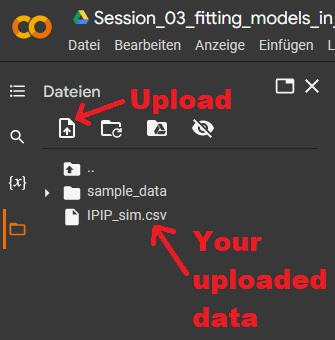

In [ ]:
# If you have uploaded it correctly this codeblock should run without error

# IF you are getting errors:
# Make sure you are in the base folder! Example: if you put the file in 
# sample_data instead you should add this to your path in the loadtxt() function
# Like so: np.loadtxt('sample_data/IPIP_sim.csv, delimiter=',')

# Similarity
ipip_sim = np.loadtxt('IPIP_sim.csv', delimiter=',')

Here we run the three models on the simulated data

In [ ]:
# Parameters
alpha = 0.1
gamma = .5

# This runs the models and gets their predictions
pred_one = RW_model(ratings, resets, alpha)
pred_two = RW_RP_model(ratings, resets, alpha, rp, gamma)
pred_three = RW_SIM_model(ratings, alpha, ipip_sim)

In [ ]:
# Plotting the results
# Model 01
plt.subplot(2,2,1)
plt.plot(ratings)
plt.plot(pred_one)
plt.title('Rescorla-Wagner Factor Model')
plt.tight_layout()
# Model 02
plt.subplot(2,2,2)
plt.plot(ratings)
plt.plot(pred_two)
plt.title('RW RP Model')
plt.tight_layout()
# Model 03
plt.subplot(2,2,3)
plt.plot(ratings)
plt.plot(pred_three)
plt.title('RW Similarity Model')
plt.tight_layout()

plt.figlegend(['Ratings','Predictions'])

You can change the parameters **alpha** and **gamma** and see how this changes the model predictions!

# Behavioural data on a personality learning task
Let's explore that data a little bit before we start work on the model fitting.

## The task
In this task participants learned about the personality traits of multiple profiles. They did this through making estimates/ guesses about specific traits and directly receiving feedback.

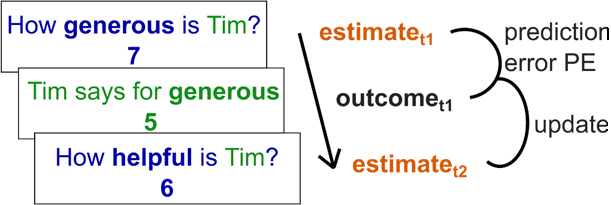



We have prepared some data already! You can upload it to this notebook in the data folder on the left side (*data_one.csv*, *data_two.csv*, *data_three.csv*). In the same way you upload the *IPIP_sim.csv* file before.

This is the data from the experiment with IPIP data, we plotted the correlation matrix from this experiment in session 02. In this experiment participants learned about 5 profile for 50 items each.

We will only plot the first 50 answers for now (i.e., the first profile) to keep the data a little more clean.

In [ ]:
# Load some participant data!
data = np.loadtxt('data_one.csv', delimiter=',')

print('The shape of the data is:',np.shape(data),'\n')
# Data from participant one has 249 trials (1 missing), furthermore we collected
# eight different kinds of data (thus 8 columns)

# Let's plot the important parts of this data and see what it contains
# The first column is the participants' answers (participant expectations)
# Python is 0-indexed so the first column is column 0, 2nd is column 1 etc.
plt.subplot(1,2,1)
plt.plot(data[1:50,0])
plt.title('Participant Answers')
plt.xlabel('Trials')
plt.ylabel('Ratings')
plt.tight_layout()

# And the second column are the profile answers (feedback)
plt.subplot(1,2,2)
plt.plot(data[1:50,1])
plt.title('Profile Answers')
plt.xlabel('Trials')
plt.ylabel('Ratings')
plt.tight_layout()

# Other columns of interest are:
# 3) Reference Point
# 4) Profile Number
# 5) Resets (for profiles and factors)
# 7) Item numbers (for the similarity matrix)

# The remaining columns we will not consider in this session

As you can see, real data is a lot messier than simulated data. But no worries, this data is still perfectly fine to use!

If you want to you can import the other two datasets and inspect their data before moving on.

# Model Fitting
So how do we fit the models on the participant data?

What we want to do is adjust the free parameters to 'fit' the data as good as possible. That is, the closer the *lines* of the model and participant data overlap the better the fit. Run the code below for a simulated example.

In [ ]:
sim_data = np.random.randint(1,10,(50,1))

good_fit = sim_data + np.random.rand(50,1)

bad_fit = sim_data + np.random.randn(50,1)*5

# Plotting
plt.subplot(1,2,1)
plt.plot(sim_data)
plt.plot(good_fit)
plt.title('Good Fitting')

plt.subplot(1,2,2)
plt.plot(sim_data)
plt.plot(bad_fit)
plt.title('Bad Fitting')

In the 'good fitting' panel the data (blue) and the model prediction (orange) overlap well. In contrary to the 'bad fitting' panel where there is very little overlap between model and data.

As straigthforward as this procedure is, it is of course impossible for us to do this by hand! One parameter might still be possible but with two or more this task becomes untractable very fast! Luckily, there are algorithms that can take care of this for us. Even better, these algorithms are already implemented in functions so we can use them right away.

We will use a function called [fmin](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) that has been implemented in the scipy library.

But before we start using these functions we have to adapt our models a little bit. The fmin algorithm needs to know how well the model is fitting for particular inputs. As a measure of fit we will use the [Sum of Squared Errors](https://en.wikipedia.org/wiki/Residual_sum_of_squares) we will calculate this inside the function and return the value.

In [ ]:
def RW_model(alpha, data):
  """ This is a simple Rescorla-Wagner model that takes as input:
  data (matrix with data), and alpha (learning rate)
  Return the SSE of the fit"""
  num_trials = len(data)
  # First we initialize a list of predictions at zero
  prediction = [0 for _ in range(num_trials+1)]
  # Now we loop over the trials and apply the model
  for trial_num in range(num_trials-1):
    # If it is the start of a new factor we predict the midpoint of the scale
    # These resets are in column 5 of the data matrix
    if data[trial_num,4] == 1:
      prediction[trial_num] = 4.5

    # Calculate the PE at a certain trial
    # For this we want to use the 2nd column of the data (profile answers)
    PE = data[trial_num,1] - prediction[trial_num]
    # Update the next prediction
    prediction[trial_num+1] = prediction[trial_num] + (alpha*PE)

  # After the predictions have been calculated we want to see how well it fits
  # We quantify this with the SSE
  SSE = np.sum((prediction[:-1] - data[:,0])**2)
  
  return float(SSE)

So now that we have rewritten the model to accept our data matrix and return a single value of fit (SSE) we can attempt to find the alpha value with the best fit.

Can you find a good alpha value?

In [ ]:
# So if we now call the function with a specific alpha parameter and participant
# data, it will return the SSE

print('The SSE with alpha .2: ',RW_model(.2,data))
print('The SSE with alpha .3: ',RW_model(.3,data))
print('The SSE with alpha .4: ',RW_model(.4,data))

So it should be a value > .2 but < .4, this might take us a long time to solve. Also, do not forget that this is only a single free parameter for a very simple model. This means that the SSE follows a curve, for any more complicated model with interactions between parameters finding the optimum gets progressively harder. Therefore let's use an optimization function to do it for us instead:

In [ ]:
# First we import optimize from the Scipy library
# This has the function we need
import scipy.optimize

In [ ]:
# This is how you make the call to use fmin
param_model_1 = scipy.optimize.fmin(RW_model, x0=.1,args=(data,))
print('\nThe best fitting parameter:', param_model_1[0],'\n')
# fmin assumes that the first variable is the one that should be optimized
# If you have more variables that are static (in our case data) they can be 
# added using the args parameter

The function will write some text that lets you know how the procedure went.

Current function value is the SSE, we can double check this by inputting the retrieved alpha value back into the function:


In [ ]:
sse = RW_model(param_model_1,data)
print('The SSE for the best alpha parameter is:',sse,'\n')

Let's adapt and fit the other two models on this dataset and see how well they fit.

This can be a bit complicated, so no worries if you don't fully understand it.

In [ ]:
# Model 2
def RW_RP_model(parameters, data):
  """ This is a combined Rescorla-Wagner and RP model that takes as input:
  ratings, reset (indicates new factor), alpha (learning rate),
  RP (list of reference points), and gamma (weighting variable)"""
  alpha = parameters[0]
  gamma = parameters[1]

  num_trials = len(data)
  # First we initialize a list of predictions at zero
  prediction = [0 for _ in range(num_trials+1)]
  pred_w_RP  = [0 for _ in range(num_trials+1)]
  # Now we loop over the trials and apply the model
  for trial_num in range(num_trials-1):
    # If it is the start of a new factor we predict the midpoint of the scale
    # Resets are column 5
    if data[trial_num,4] == 1:
      prediction[trial_num] = 4.5

    # Calculate the PE at a certain trial
    PE = data[trial_num,1] - prediction[trial_num]
    # Update the next prediction
    prediction[trial_num+1] = prediction[trial_num] + (alpha*PE)
    
    # Here we add the RP part
    pred_w_RP[trial_num] = gamma * data[trial_num,2] + ((1-gamma)*prediction[trial_num])

  SSE = np.sum((pred_w_RP[:-1] - data[:,0])**2)
  return float(SSE)

In [ ]:
# Model 03
def RW_SIM_model(alpha, data, sim):
  """ This is a combined Rescorla-Wagner and Similarity model that takes as input:
  ratings, alpha (learning rate), sim (correlation matrix of items)"""
  # For this model we will split it up per profile
  prediction = []
  for prof in range(1,6):
    # Take only the profile data
    profData = data[data[:,3] == prof,:]
    profLen = len(profData)
    # First we initialize a list of predictions at the midpoint!
    profPred = [4.5 for _ in range(profLen)]
    # Now we loop over the trials and apply the model
    for trial_num in range(profLen):
      # Calculate the PE at a certain trial
      PE = profData[trial_num,1] - profPred[trial_num]
      # Update the next prediction
      for idx in range(profLen):
        profPred[idx] = profPred[idx] + (alpha*PE*sim[trial_num,int(profData[idx,6]-1)])
    prediction = prediction + profPred
  
  SSE = np.sum((prediction - data[:,0])**2)
  return SSE

In [ ]:
param_model_2 = scipy.optimize.fmin(RW_RP_model, x0=[.1,.5],args=(data,))
print('\nThe best parameters for model 2 are, alpha:',param_model_2[0],'and gamma: ',param_model_2[1],'\n')
param_model_3 = scipy.optimize.fmin(RW_SIM_model, x0=.1, args=(data,ipip_sim))
print('\nThe best alpha parameter for model 3 is:',param_model_3[0],'\n')

# But what does this all mean?
So we now know how to build models and how to fit them to participants' data. But what does this actually tell us? How can we use this information to pick a best fitting model?

We can use the [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) as metric of fit. The BIC-value gives a good indication which of the models we are comparing is best at explaining participants' data. What's special about the BIC is that it takes the number of parameters of each model into account. This is important because arbitrarily adding parameters will make the model fit better (see [overfitting](https://en.wikipedia.org/wiki/Overfitting)) but does not help us explain the data. The BIC thus ensures that we will only add parameters when they are necessary in explaining an important part of the data. To calculate the BIC when using the SSE we use the following formula:

$BIC = n * log(SSE/n) + κ*log(n)$

where $n$ is the number of trials and $κ$ the number of parameters.

Let's put this equation in a function that takes the three parameters and returns the BIC value:


In [ ]:
def calc_BIC(SSE,numTrials,numParam):
  """ Takes input SSE, number of trials, & number of parameters
  returns the BIC value"""
  bic = (numTrials * np.log(SSE/numTrials)) + (numParam*np.log(numTrials))
  return bic

Let's now compare the BIC values from each of the models we just fit on the first participant.

In [ ]:
# First we'll get the SSE's back from the models
SSE_one   = RW_model(param_model_1,data)
SSE_two   = RW_RP_model(param_model_2, data)
SSE_three = RW_SIM_model(param_model_3, data, ipip_sim)

# Number of trials is the length of the data
numTrials = len(data)

bic_one   = calc_BIC(SSE_one,numTrials,1)   # Model 1 has 1 parameter
bic_two   = calc_BIC(SSE_two,numTrials,2)   # Model 2 has 2 parameters
bic_three = calc_BIC(SSE_three,numTrials,1) # Model 3 has 1 parameter

print('The BIC for model 1 on participant one is:',bic_one,'\n')
print('The BIC for model 2 on participant one is:',bic_two,'\n')
print('The BIC for model 3 on participant one is:',bic_three,'\n')

So in this case Model 1 is the best fitting model with a slightly better fit than model 2.

Of course this is an interesting way of looking at the data but it would be better to automate it a bit more. Let's put the data of the three participant together and run our analysis in a loop.

Make sure you have *data_one.csv*, *data_two.csv*, & *data_three.csv* in you data folder on the left.

In [ ]:
# Load all the data and put it together in a tuple named data
data_one = np.loadtxt('data_one.csv', delimiter=',')
data_two = np.loadtxt('data_two.csv', delimiter=',')
data_three = np.loadtxt('data_three.csv', delimiter=',')

all_data = (data_one,data_two,data_three)

Why can't we put the data in a big 3 dimensional matrix?
hint: have a look at the size (np.shape()) of each individual data set.

Now we can loop over the data, fit the models, retrieve the SSE's, and calculate the BICs.

Let's save all the values in separate matrices so we can have a look at them afterwards!


In [ ]:
# Setup
# These are all the values we want to save
param_mat = np.zeros((3,3)) # Alpha parameters
param_gam = np.zeros(3) # Gamma parameters for model 2
sse_mat = np.zeros((3,3))
bic_mat = np.zeros((3,3))

# Loop over the data (enumerate allows us to have the index = idx)
for idx, d in enumerate(all_data):
  # Number of trials per participant
  numTrials = len(d)

  # -=-=-=-=-=-=-=-=- Model Fitting -=-=-=-=-=-=-=-=-
  param_mat[idx,0] = scipy.optimize.fmin(RW_model, x0=.1,args=(d,))

  # Because model 2 returns 2 parameters we need to save it a little different
  param = scipy.optimize.fmin(RW_RP_model, x0=[.1,.5],args=(d,))
  param_mat[idx,1] = param[0]
  param_gam[idx] = param[1]
  
  param_mat[idx,2] = scipy.optimize.fmin(RW_SIM_model, x0=.1, args=(d,ipip_sim))

  # -=-=-=-=-=-=-=-=- Calculating SSE's -=-=-=-=-=-=-=-=-
  sse_mat[idx,0] = RW_model(param_mat[idx,0], d)
  sse_mat[idx,1] = RW_RP_model([param[0],param[1]], d)
  sse_mat[idx,2] = RW_SIM_model(param_mat[idx,2], d, ipip_sim)

  # -=-=-=-=-=-=-=-=-  -=-=-=-=-=-=-=-=-
  bic_mat[idx,0] = calc_BIC(sse_mat[idx,0],numTrials,1)
  bic_mat[idx,1] = calc_BIC(sse_mat[idx,1],numTrials,2)
  bic_mat[idx,2] = calc_BIC(sse_mat[idx,2],numTrials,1)
  # -=-=-=-=-=-=-=-=- -=-=-=-=-=-=-=-=-


In [ ]:
# Let's have a look at the BIC values we calculated
print('This is the BIC matrix we calculated')
print('Each row is a participant and each column a model')
print(bic_mat,'\n')

# If we sum the BIC values we get an idea how good the models performed on average
print('The summed BIC values for each model are:')
bic_sum = np.sum(bic_mat,axis=0)
print(bic_sum,'\n')

# In plotting we normally subtract the values from a reference value
# Let's take model 3 here (because it has the worse fit).
bicVal = np.zeros(3)
for b in range(3):
  bicVal[b] = bic_sum[b] - max(bic_sum)

print(bicVal)

Let's plot the data and see what model is the best fit!

In [ ]:
# Plot a horizontal bar plot
plt.barh([3,2,1],bicVal)

# Figure make-up
plt.yticks([3,2,1])
ax = plt.gca()
ax.set_yticklabels(['Model 1 (RW)','Model 2 (RW & RP)','Model 3 (SIM)'])
plt.xlabel('Summed BIC')
plt.title('Results')
plt.show()

# Conclusion
So model 2 seems to be the best fitting model from the three we created. Of course, we only tested three participants so these results might still change with more participants.

You have now had a real quick introduction to modelling. Due to time constraints we could only offer you a very broad look but the general idea should be there.

To still mention some important stuff we skipped:
* Model-Free analysis: *regular* analyses (e.g., correlations) that do not rely on computational modelling.
* Confusion Matrix: to see if you can distinguish your models from one another. If you can't your model comparison makes no sense.
* Parameter Recovery: to see if there parameters you receive from model fitting are also the ones that created the data.

# Extra time
* You can play around with all the plots (e.g., change the colors)!

* You can also rewrite the analyses to be a lot smaller. E.g., can you output the SSE together with the parameters so you don't have to recalculate it ([Scipy Documentation](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.optimize.fmin.html))?

* Implement one of your own models?

* Have a look at creating a confusion matrix and parameter recover [good reference paper on modelling in general](https://elifesciences.org/articles/49547)